# Whale Classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import dill as pickle

In [3]:
PATH = './data/whale/'
arch = resnet34
sz = 224
bs = 64

In [4]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [5]:
# train_df = pd.read_csv(label_csv)
# train_df['Id'] = train_df['Id'].astype('category')
# whale_ids = train_df['Id'].unique()
# whale_ids2num = {k: v for k,v in zip(whale_ids, range(len(whale_ids)))}
# train_df['Id'] = train_df['Id'].map(whale_ids2num)
# train_df.to_csv(label_csv, index=False)
# pickle.dump(whale_ids2num, open('whale_ids2num.pkl', 'wb'))

# Data Transform

In [6]:
augs = [
    RandomFlip(),
    RandomLighting(0.1, 0.1),
    RandomRotate(3)
]

def get_data(sz, bs, val):
    tfms = tfms_from_model(arch, sz, aug_tfms=augs, crop_type=CropType.NO)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test',
                                        val_idxs=val, tfms=tfms, bs=bs)
    return data

# Find Learning Rate

In [7]:
data = get_data(sz,bs,val_idxs)

In [8]:
learn = ConvLearner.pretrained(arch, data, ps=0.5)

In [9]:
lrf = learn.lr_find()

 94%|█████████▎| 116/124 [00:56<00:03,  2.05it/s, loss=21.1]

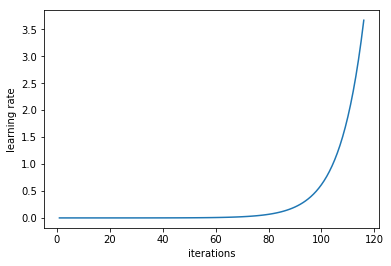

In [10]:
learn.sched.plot_lr()

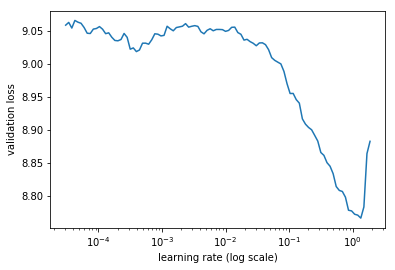

In [11]:
learn.sched.plot()

In [12]:
lr = 1e-1

In [13]:
lrs = np.array([lr/1000,lr/100,lr/10])

# Improve Model

In [14]:
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                   
    0      7.999906   7.624155   0.079188  
    1      7.106238   7.319226   0.080711                   
    2      6.470433   7.138557   0.086802                   


[array([7.13856]), 0.08680203041146854]

In [15]:
learn.precompute = False

In [16]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      5.466029   7.038416   0.113198  
    1      5.104895   6.968334   0.132487                   
    2      4.763652   6.977188   0.140102                   


[array([6.97719]), 0.14010152280860141]

In [17]:
learn.save('resnet34_224_lastlayer4')

In [18]:
learn.load('resnet34_224_lastlayer4')

In [19]:
learn.unfreeze()

In [20]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      4.798143   6.927745   0.135533  
    1      4.284864   6.806366   0.154822                   
    2      3.836162   6.751346   0.163959                   
    3      3.803399   6.727684   0.172589                   
    4      3.498481   6.713015   0.175127                   
    5      3.141927   6.685105   0.185279                   
    6      2.979371   6.693764   0.184264                   


[array([6.69376]), 0.18426395946650337]

In [21]:
learn.save('resnet34_224_all4')

In [22]:
learn.load('resnet34_224_all4')

# Increase Data Image Size

In [23]:
sz = 320

In [24]:
data = get_data(sz,bs,val_idxs)
learn.set_data(data)

In [25]:
learn.freeze()

In [26]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      4.219619   6.797022   0.172589  
    1      3.808065   6.775726   0.182234                   
    2      3.426869   6.833388   0.186802                   


[array([6.83339]), 0.18680203032070006]

In [27]:
learn.save('resnet34_320_last_layer4')

In [28]:
learn.load('resnet34_320_last_layer4')

In [29]:
learn.unfreeze()

In [30]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.621815   6.718094   0.206599  
    1      2.470424   6.689084   0.218782                   
    2      2.181616   6.654625   0.226396                   
    3      2.148085   6.677298   0.227411                   
    4      1.935307   6.657246   0.236548                   
    5      1.681367   6.677653   0.245685                   
    6      1.576075   6.693194   0.244162                   


[array([6.69319]), 0.2441624364120706]

In [31]:
learn.save('resnet34_320_all4')

In [42]:
learn.load('resnet34_320_all4')

# Train with Everything

In [43]:
# Move all validation data except one (due to fastai limitation) to training data
data = get_data(sz,bs,[0])
learn.set_data(data)

In [44]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.790753   11.829232  0.0       
    1      2.749229   11.761403  0.0                        
    2      2.553806   11.805371  0.0                        
    3      2.602135   11.612578  0.0                        
    4      2.489865   11.461729  0.0                        
    5      2.366127   11.538072  0.0                        
    6      2.268994   11.614325  0.0                        


[array([11.61432]), 0.0]

# Create Submission

In [45]:
probs, _ = learn.TTA(is_test=True)

In [46]:
# Assemble our data frame
mean_probs = np.mean(probs, axis=0) # Average probs from TTA
probs_sorted = np.argsort(-mean_probs,axis=1)[:,:5] # Get top 5 predictions

In [47]:
import dill as pickle
whale_ids2num = pickle.load(open('whale_ids2num.pkl', 'rb'))

In [48]:
fnames = [f[5:] for f in data.test_ds.fnames] # get rid of folder prefix

num2whale = [k for k,v in whale_ids2num.items()]

def probs2whale(x):
    return num2whale[int(data.classes[x])]

probs2whale = np.vectorize(probs2whale)

def join_with_spaces(arr):
    return ' '.join(arr)

whales = np.apply_along_axis(join_with_spaces, 1, probs2whale(probs_sorted))

In [49]:
df = pd.DataFrame({'Image': fnames, 'Id': whales}, columns=['Image','Id'])
df.to_csv('submission6b.csv', index=False)

In [50]:
!kaggle competitions submit -c whale-categorization-playground -f submission6b.csv -m "8th, training with 80% data, lr/1000,lr/100,lr/10"

Successfully submitted to Humpback Whale Identification Challenge

Kaggle Score: 0.41210 (6 using 80% training data)

Kaggle Score: ? (6b using 100% training data)